## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp
#!pip install pytorch-transformers

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [0]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## Load Dataset


In [0]:
def load_data(filename):
    from sklearn.utils import Bunch
    def decodeText(text):
        if type(text) != str:
            try:
                text = text.decode('utf-8')
            except:
                text = text.decode('latin-1')
        text = text.rstrip()
        return text.split('@')
    
    contexts, labels = [], []
    with open(filename, 'rb') as f:
        text = f.readlines()
    
    for t in tqdm(text):
        context, label = decodeText(t)
        contexts += [context]
        if label == 'positive':
            target = 1
        elif label == 'negative':
            target = -1
        elif label == 'neutral':
            target = 0
        else:
            raise('ERROR: ' + label)
        labels += [target]
        
#    return Bunch(contexts = contexts, labels = np.array(labels))
    return pd.DataFrame(zip(contexts, labels), columns = ['contexts','labels'])
def preprocessing(data):
    """
    input:
        - data is a dataframe with columns contexts as series of text
    output:
        - preprocessed dataframe
    """
    import string
    import re
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.wordnet import WordNetLemmatizer
    
    # lowercase 
    data.contexts = data.contexts.apply(lambda x: ' '.join(word.lower() for word in x.split()))
    
    data.contexts = data.contexts.apply(lambda x: re.sub(r"don't", "do not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"aren't", "are not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"couldn't", "could not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"didn't", "did not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"doesn't", "does not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"hadn't", "had not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"hasn't", "has not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"haven't", "have not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"isn't", "is not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"mightn't", "might not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"mustn't", "must not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"needn't", "need not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"shan't", "shall not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"wasn't", "was not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"weren't", "were not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"won't", "will not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"wouldn't", "would not", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"shouldnt", "should not", x))
    
    # remove numbers
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\d+", '', x))
    # remove punctuations
    # data.contexts = data.contexts.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"what's", "what is ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'s", " ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'ve", " have ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"i'm", "i am ",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'re", " are ",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\'d", " would ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"!", " ! ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\/", " ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\^", " ^ ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\+", " + ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\-", " - ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"(\d+)(k)", r"\g<1>000", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r":", " : ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" e g ", " eg ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" b g ", " bg ",x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" u s ", " american ", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\0s", "0",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r" 9 11 ", "911",  x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"e - mail", "email", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"j k", "jk", x))
    data.contexts = data.contexts.apply(lambda x: re.sub(r"\s{2,}", " ", x))
    
    




    # remove whitespace
    data.contexts = data.contexts.apply(lambda x: x.strip())
    # tokenization
    data.contexts = data.contexts.apply(word_tokenize)
    # remove stop words
    #stop_words = stopwords.words('english')
    #for word in ['above', 'below','up','down', 'more', 'not']:
    #    stop_words.remove(word)
    #data.contexts = data.contexts.apply(lambda x: [word for word in x if word not in stop_words])
    # stemming
    lemmatizer = WordNetLemmatizer()
    data.contexts = data.contexts.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])



In [0]:
data = load_data('Sentences_AllAgree.txt')
preprocessing(data)

100%|██████████| 2264/2264 [00:00<00:00, 282944.62it/s]


In [0]:
df = pd.DataFrame(zip([' '.join(sent) for sent in data.contexts],data.labels), columns = ['contexts','labels'])

In [0]:
df.shape

(2264, 2)

In [0]:
df.labels = df.labels + 1

In [0]:
df.sample(10)

,contexts,labels
1082,the increase range will vary up to % .,1
1493,the purchase price wa not disclosed .,1
1156,after april cencorp will not have any own empl...,1
428,finnair plc carried a record . million passeng...,2
1886,"operating loss totalled eur . mn , compared to...",0
278,"mr ashley , deputy executive chairman of sport...",1
68,"operating profit wa eur . mn , up from eur . mn .",2
164,operating profit rose to eur . mn from eur . m...,2
797,"according to pkc , the acquisition would bring...",2
1186,"capman , with office in helsinki , stockholm ,...",1


In [0]:
# Create sentence and label lists
sentences = df.contexts.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.labels.values

## Inputs

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'according', 'to', 'gran', ',', 'the', 'company', 'ha', 'no', 'plan', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

In [0]:
max([len(sent) for sent in tokenized_texts])

85

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 85

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
input_ids

array([[ 101, 2429, 2000, ...,    0,    0,    0],
       [ 101, 2005, 1996, ...,    0,    0,    0],
       [ 101, 1999, 1996, ...,    0,    0,    0],
       ...,
       [ 101, 2414, 3006, ...,    0,    0,    0],
       [ 101, 4082, 5618, ...,    0,    0,    0],
       [ 101, 5096, 1999, ...,    0,    0,    0]])

In [0]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size = 0.2, shuffle = True, random_state = 1)
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(validation_inputs, validation_labels,test_size = 0.5, shuffle = True, random_state = 1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size = 0.2, shuffle = True, random_state = 1)
validation_masks, test_masks, _, _ = train_test_split(validation_masks, _,test_size = 0.5, shuffle = True, random_state = 1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


## Train Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.



### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  



In [0]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [0]:
from sklearn.metrics import f1_score
def flat_accuracy(preds, labels):
    return f1_score(labels, np.argmax(preds, axis = 1), average = 'macro')

In [0]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    #print(logits)
    #print(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 0.4495509997206299


Epoch:  25%|██▌       | 1/4 [01:05<03:16, 65.49s/it]

Validation Accuracy: 0.9327923822660664
Train loss: 0.13009206636955864


Epoch:  50%|█████     | 2/4 [02:10<02:10, 65.42s/it]

Validation Accuracy: 0.9036903899755562
Train loss: 0.04314804032624683


Epoch:  75%|███████▌  | 3/4 [03:15<01:05, 65.32s/it]

Validation Accuracy: 0.9215232040928185
Train loss: 0.03063301323798665


Epoch: 100%|██████████| 4/4 [04:20<00:00, 65.24s/it]

Validation Accuracy: 0.9389733993061717


## Training Evaluation

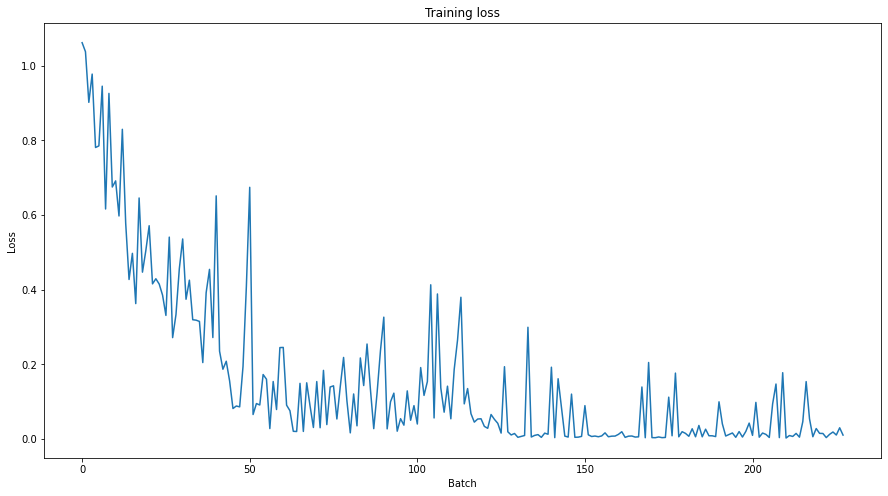

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [0]:
flat_accuracy(flat_predictions, flat_true_labels)

0.9320821713223304